In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import argparse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import json
from functools import partial
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import time
import seaborn as sn
 
from tianshou.utils import WandbLogger
from tianshou.data import Batch, Collector, ReplayBuffer, VectorReplayBuffer
from tianshou.env import DummyVectorEnv
from tianshou.policy import BasePolicy, PPOPolicy, PGPolicy, A2CPolicy
from tianshou.trainer import OnpolicyTrainer
from tianshou.utils.net.common import ActorCritic, Net
#from tianshou.utils.net.discrete import Actor, Critic
from tianshou.utils.net.continuous import Actor, Critic, ActorProb
from tianshou.trainer.utils import gather_info, test_episode

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit, RescaleAction, TransformObservation
from stable_baselines3.common.env_checker import check_env

from lib.environments import *
from lib.policy import MarlPPOPolicy
from lib.distributions import ElementwiseNormal
from lib.models import get_actor_critic
from lib.utils import str2bool, Config, dict_to_wandb_table, restrict_to_num_threads
from lib.trainer import MyOnpolicyTrainer
from lib.models import FcNN, MyFCNNActorProb, MyFCNNCriticProb
from lib.models import *

#temporary solution for xlb imports
sys.path.append(os.path.abspath('/home/pfischer/XLB'))
#from my_flows.kolmogorov_2d import Kolmogorov_flow
from my_flows.helpers import get_kwargs


#from lib.custom_tianshou.my_actors import MyActorProb

import wandb
wandb.require("core")

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(42)
torch.manual_seed(42)

In [5]:
def plot_policy(mean, std, v):
    plt.style.use('ggplot')
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    im1 = axs[0].imshow(mean, cmap='viridis', aspect='equal')
    im2 = axs[1].imshow(std, cmap='viridis', aspect='equal')
    im3 = axs[2].imshow(v, cmap=sn.cm.icefire, vmin=-10, vmax=10)
    #axs[2].invert_xaxis()


    axs[0].set_title(r"policy mean $\mu$")
    axs[1].set_title(r"policy std $\sigma$")
    #axs[2].set_title(r"sampled actions $a \sim \mathcal{N}(\mu, \sigma)$")
    axs[2].set_title(r"vorticity field")
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_yticks([])
    axs[1].set_xticks([])
    axs[2].set_yticks([])
    axs[2].set_xticks([])


    cbar1 = fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
    cbar2 = fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
    cbar3 = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
    plt.show()

In [9]:
# load args
DUMP_PATH = "dump/Kolmogorov6_ppo_cgs1_fgs16/"

with open(DUMP_PATH+'config_20240810-020145.pkl', 'rb') as f:
    args = pickle.load(f)

In [10]:
seeds = np.array([102, 348, 270, 106, 71, 188, 20, 121, 214, 330, 87, 372,
                  99, 359, 151, 130, 149, 308, 257, 343, 413, 293, 385, 191, 276,
                  160, 313, 21, 252, 235, 344, 42])

assert seeds.shape[0] == np.unique(seeds).shape[0]
train_seeds = seeds[:30]
val_seeds = seeds[30:]
#test_seeds = np.array([69, 33, 420])

#train_env = KolmogorovEnvironment7(seeds=train_seeds, max_episode_steps=args.max_interactions, step_factor=args.step_factor)
#test_env = KolmogorovEnvironment7(seeds=val_seeds, max_episode_steps=args.max_interactions, step_factor=args.step_factor)

In [11]:
actor = MyFCNNActorProb(in_channels=2, device=device).to(device)
critic = MyFCNNCriticProb(in_channels=2, device=device).to(device)
optim = torch.optim.Adam(actor.parameters(), lr=args.learning_rate, eps=args.adam_eps)
dist = torch.distributions.Normal
policy = MarlPPOPolicy(actor=actor,
    critic=critic, 
    optim=optim,
    dist_fn=dist, 
    action_space=train_env.action_space,
    discount_factor=args.gamma,
    reward_normalization=args.reward_normalization, 
    deterministic_eval=args.deterministic_eval,
    action_scaling=args.action_scaling,
    action_bound_method=args.action_bound_method,
    ent_coef = args.ent_coef,
    max_grad_norm = args.max_grad_norm,
    gae_lambda=args.gae_lambda, 
)

NameError: name 'train_env' is not defined

In [12]:
#######################################################################################################
####### Collectors ####################################################################################
#######################################################################################################
#train_collector = Collector(policy=policy, env=train_env, buffer=VectorReplayBuffer(args.buffer_size, len(train_env)))
train_collector = Collector(policy=policy, env=train_env, buffer=VectorReplayBuffer(args.buffer_size, 1))
test_collector = Collector(policy=policy, env=test_env)
train_collector.reset()
test_collector.reset()

#######################################################################################################
####### Trainer #######################################################################################
#######################################################################################################
trainer = OnpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=2,
    step_per_epoch=args.step_per_epoch,
    repeat_per_collect=args.repeat_per_collect,
    episode_per_test=args.episode_per_test,
    batch_size=args.batch_size,
    step_per_collect=args.step_per_collect,
    #episode_per_collect=args.episode_per_collect,
    show_progress=True,
    #stop_fn=lambda mean_reward: mean_reward >= args.reward_threshold,
)

NameError: name 'policy' is not defined

In [ ]:
trainer.run()

# iterate through all seeds and print intial voriticity in a grid

In [ ]:
vorts = np.zeros((seeds.shape[0], 128,128))
for i in range(seeds.shape[0]):
    env = KolmogorovEnvironment6(seeds=np.array([seeds[i]]))
    vorts[i,...] = env.get_vorticity()
    env.close()


In [ ]:
# plot vorticity images at times t1 to t5 for all resolutions
bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="none", facecolor="white", alpha=0.8)
fig, axs = plt.subplots(4, 8, figsize=(8,4), dpi=300)
# add tight layout
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for i in range(8):
    for j in range(4):     
        axs[j, i].imshow(vorts[4*i+j], vmin=-12, vmax=12, cmap=sn.cm.icefire)
        #axs[j, i].axis('off')
        # disable ticks 
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        axs[j, i].text(0.04, 0.04, f"{seeds[4*i+j]}", ha='left', va='bottom', fontsize=6, color='black', bbox=bbox_props, transform=axs[j,i].transAxes)
plt.show()

# plot energy spectrum over the coarse of a simulation between fgs and cgs

In [13]:
env = KolmogorovEnvironment7(seeds=train_seeds, max_episode_steps=1536-1, step_factor=1)

m = 310.3835047163428, m_prime = 1535.9999999999998, end time = 1536 steps, T=18, io_rate = 66.78260869565216, Number of outputs = 25.0
m = 4966.136075461485, m_prime = 24575.999999999996, end time = 24576 steps, T=18, io_rate = 1068.5217391304345, Number of outputs = 25.0


0 0
Correlation: 0.9991326297480867
MSE: 8.389118945742234e-05
NMSE: 8.060004477498618e-05
pointwise relative mse: 1.0171380309686808


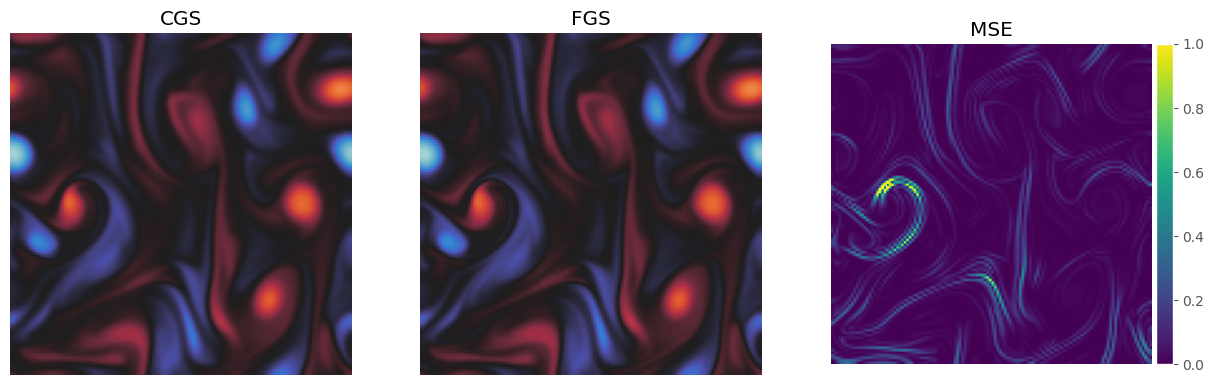

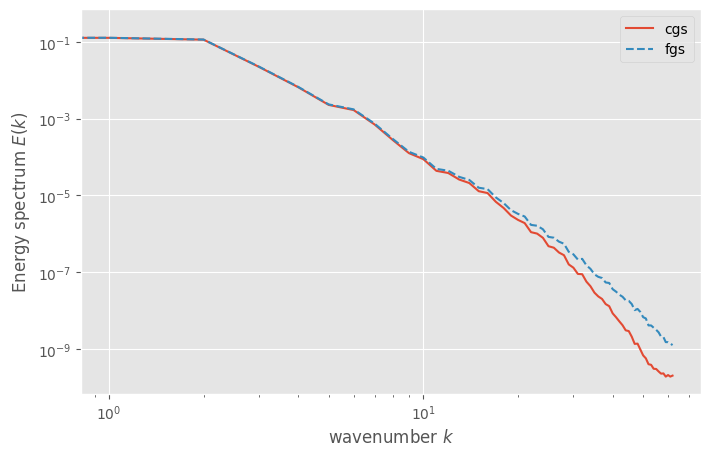

500 1.0
Correlation: 0.9990183067108508
MSE: 0.00030073056184676424
NMSE: 0.0002917859556706777
pointwise relative mse: 1.581367881979256


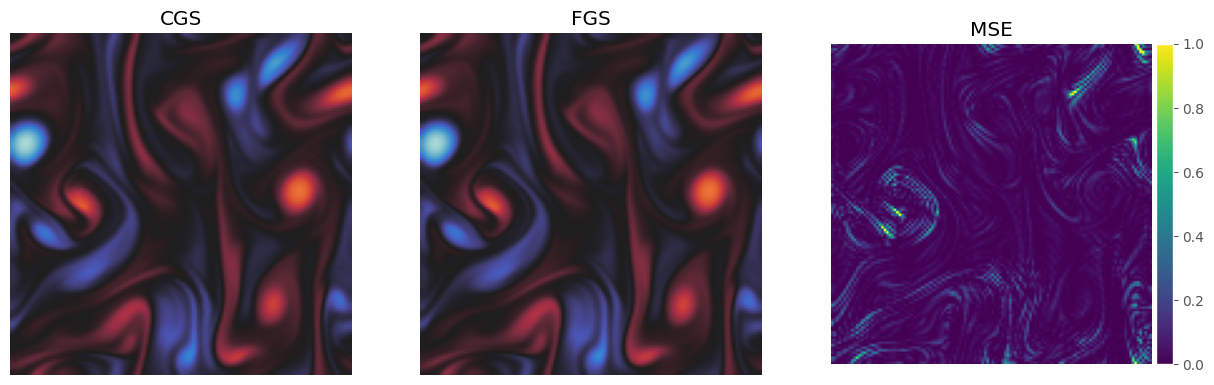

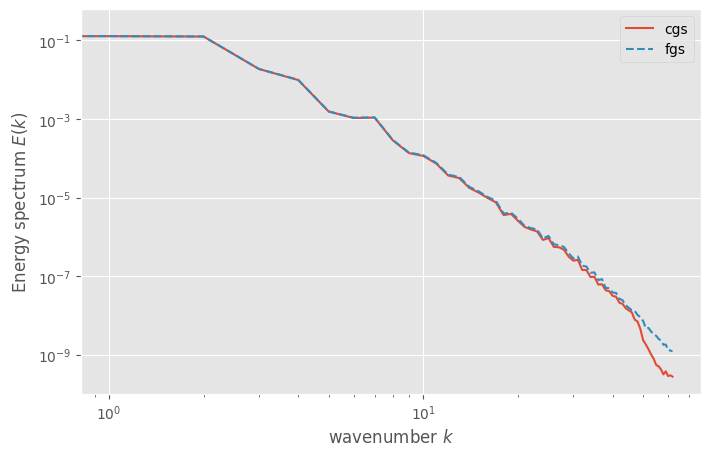

1000 1.0
Correlation: 0.9972502523198898
MSE: 0.0011749749171001338
NMSE: 0.0011594534479672657
pointwise relative mse: 242.6928728779077


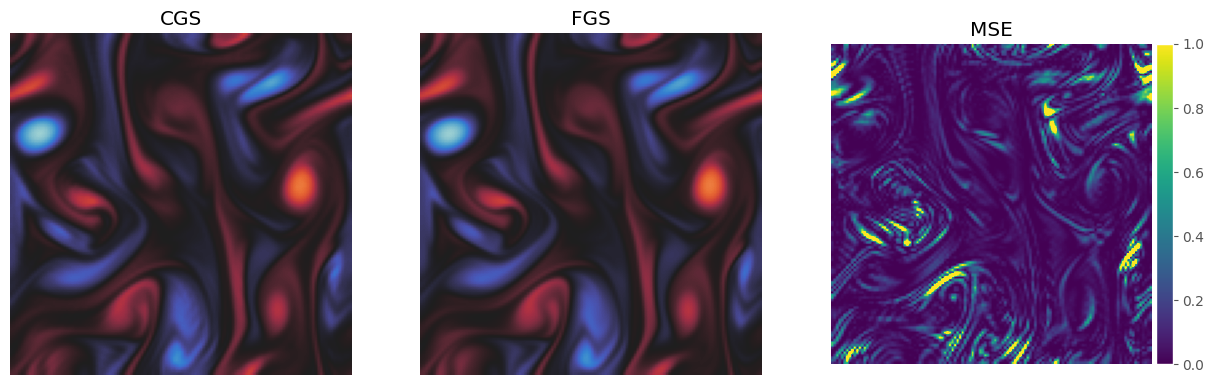

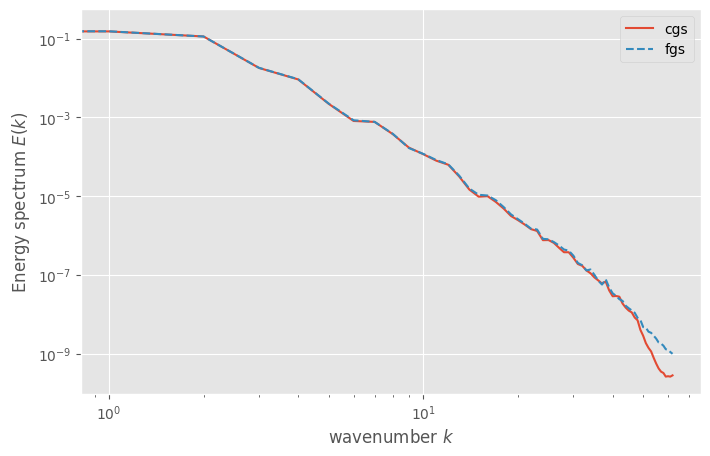

1500 1.0
Correlation: 0.9935997566613785
MSE: 0.0027270078502752092
NMSE: 0.0027032985889776655
pointwise relative mse: 50.588289619347606


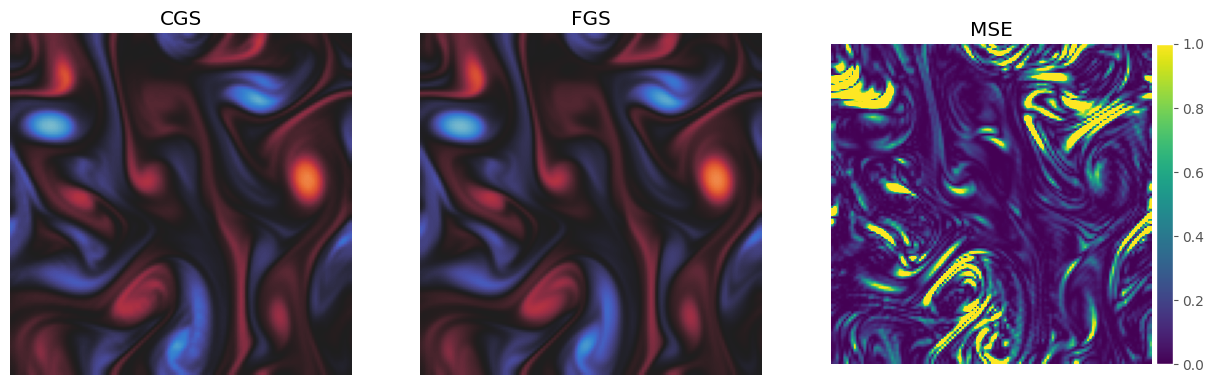

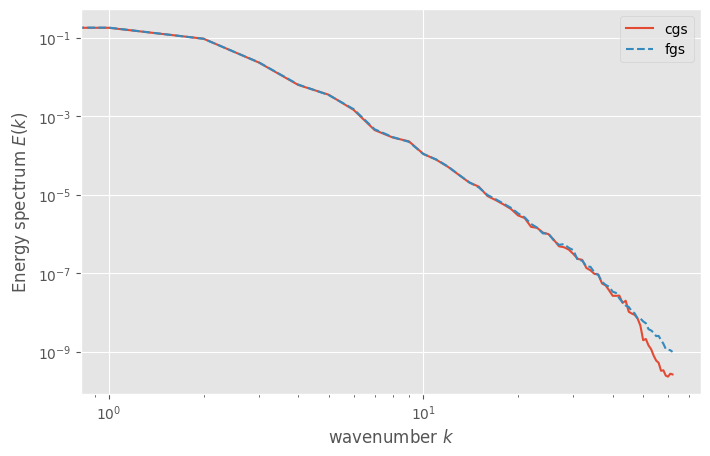

truncated
#steps = 1535, Total Reward = 1535.0, Total discounted Reward = 99.99998004628753
Execution time: 7.278422832489014 seconds


In [15]:
import time
#time one klmgrv5 episode
start_time = time.time()
reward = 0
discounted_reward = 0
f_min, f_max, f_mean=0.1,0.1,0.
gamma = 0.99
step = 0
act = np.ones(env.action_space.shape)
#act[32:96, 32:96] = 0.92
obs ,inf = env.reset()
rew = 0
episode_is_over = False
while not episode_is_over:
    if step%500==0:
        print(step, rew)
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        env.render()

        #plot enerty spectra
        E1, E2 = env.get_spectra()
        plt.style.use('ggplot')
        plt.figure(figsize=(8, 5), dpi=100)
        plt.loglog(E1, label='cgs')
        plt.loglog(E2, linestyle='dashed', label='fgs')
        plt.ylabel(r'Energy spectrum $E(k)$')
        plt.xlabel(r'wavenumber $k$')
        plt.legend()
        plt.show()

    obs, rew, terminated, truncated, inf = env.step(act)
    reward += rew
    discounted_reward += rew * gamma**step 
    f_min = np.min([f_min, env.f1.min()])
    f_max = np.max([f_min, env.f1.max()])
    f_mean += env.f1.mean()
    step += 1
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

f_mean /= step

print(f"#steps = {step}, Total Reward = {reward}, Total discounted Reward = {discounted_reward}")
env.close()

end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

In [18]:
f_min

0.022171514431137535

# load and look at trained policz

In [6]:
# load args
DUMP_PATH = "dump/Kolmogorov9_ppo_cgs1_fgs16/"
#ID = "20240813-170058"
ID = "20240827-132033"

with open(DUMP_PATH+'config_'+ID+'.pkl', 'rb') as f:
    args = pickle.load(f)

In [7]:
 #######################################################################################################
####### environments ##################################################################################
#######################################################################################################
seeds = np.array([102, 348, 270, 106, 71, 188, 20, 121, 214, 330, 87, 372,
              99, 359, 151, 130, 149, 308, 257, 343, 413, 293, 385, 191, 276,
              160, 313, 21, 252, 235, 344, 42])
assert seeds.shape[0] == np.unique(seeds).shape[0]
train_seeds = seeds[:29]
val_seeds = seeds[29:]
#test_seeds = np.array([69, 33, 420])

train_env = KolmogorovEnvironment8(seeds=train_seeds, max_episode_steps=args.max_interactions, step_factor=args.step_factor)
test_env = KolmogorovEnvironment8(seeds=val_seeds, max_episode_steps=args.max_interactions, step_factor=args.step_factor)

m = 310.3835047163428, m_prime = 1535.9999999999998, end time = 1536 steps, T=18, io_rate = 66.78260869565216, Number of outputs = 25.0
m = 4966.136075461485, m_prime = 24575.999999999996, end time = 24576 steps, T=18, io_rate = 1068.5217391304345, Number of outputs = 25.0
m = 310.3835047163428, m_prime = 1535.9999999999998, end time = 1536 steps, T=18, io_rate = 66.78260869565216, Number of outputs = 25.0
m = 4966.136075461485, m_prime = 24575.999999999996, end time = 24576 steps, T=18, io_rate = 1068.5217391304345, Number of outputs = 25.0


In [8]:
#######################################################################################################
####### Policy ########################################################################################
#######################################################################################################
actor = MyFCNNActorProb2(in_channels=2, device=device).to(device)
critic = MyFCNNCriticProb2(in_channels=2, device=device).to(device)
optim = torch.optim.Adam(actor.parameters(), lr=args.learning_rate, eps=args.adam_eps)
dist = torch.distributions.Normal
policy = MarlPPOPolicy(actor=actor,
    critic=critic, 
    optim=optim,
    dist_fn=dist, 
    action_space=train_env.action_space,
    discount_factor=args.gamma,
    reward_normalization=args.reward_normalization, 
    deterministic_eval=True,
    action_scaling=args.action_scaling,
    action_bound_method=args.action_bound_method,
    ent_coef = args.ent_coef,
    vf_coef = args.vf_coef,
    max_grad_norm = args.max_grad_norm,
    gae_lambda=args.gae_lambda, 
)

In [9]:
#load trained bolicy
policy.load_state_dict(torch.load(DUMP_PATH+'policy_'+ID+'.pth'))

<All keys matched successfully>

mean=0.03481652960181236, std=0.33941683173179626, act=0.03481652960181236, scaled act = 1.000173807144165
rew- mean0.00023096192574677412 +- 0.0033674102571698236 in [-0.023570780866655292,0.02005721053224092]
Correlation: 0.9977850391637919
MSE: 0.0006948626125882521
NMSE: 0.0006801938809739981
pointwise relative mse: 206.34447955248044


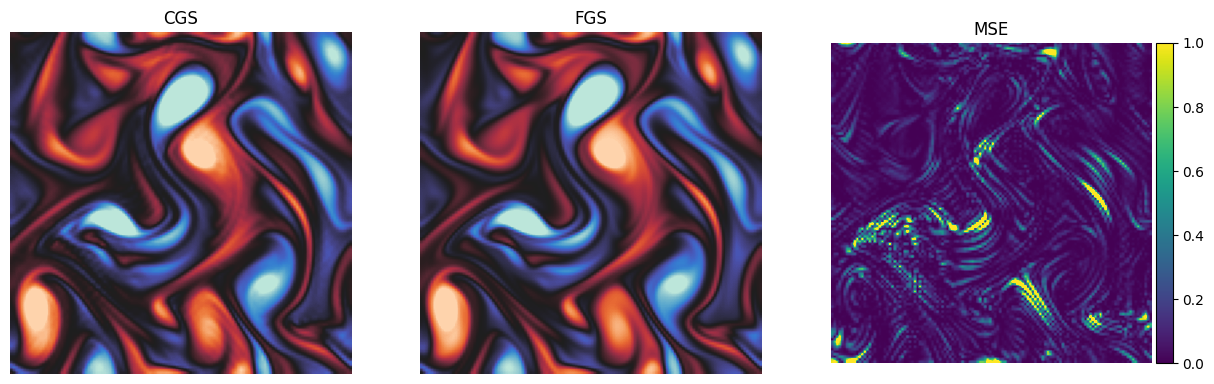

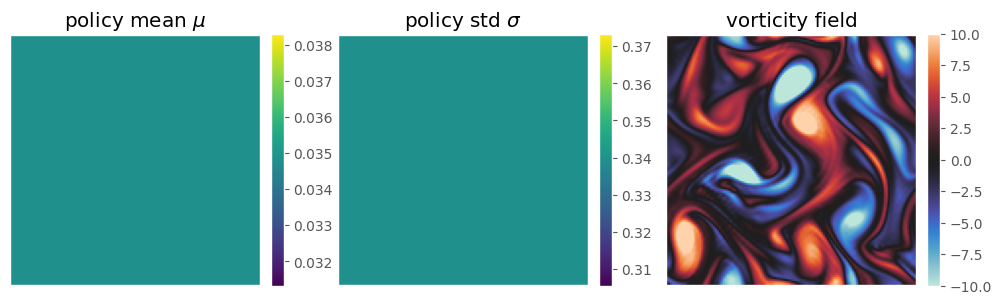

truncated
#steps = 384, Total Reward = 0.07982142339043613


In [10]:
# just plays one episode
reward = 0
step = 0
policy.eval()
obs ,inf = test_env.reset()
act_means = []
act_maxs = []
act_mins = []
act_stds = []
std_means = []
episode_is_over = False
act = np.ones(test_env.action_space.shape)
while not episode_is_over:
    batch = policy(Batch(obs=np.array([obs]), info=inf))
    logits = batch.logits.detach().cpu().numpy()
    action = batch.act[0].detach().cpu().numpy()
    act = policy.map_action(action)
    #act_means.append(logits[0].reshape(128,128).mean())
    #act_mins.append(logits[0].reshape(128,128).min())
    #act_maxs.append(logits[0].reshape(128,128).max())
    act_means.append(act.reshape(128,128).mean())
    act_mins.append(act.reshape(128,128).min())
    act_maxs.append(act.reshape(128,128).max())
    act_stds.append(act.reshape(128,128).std())
    #print(logits, action, act)
    obs, rew, terminated, truncated, inf = test_env.step(act)
    reward += rew
    step += 1
    if step%200==0:
        #print(f"step: {step}, actual_steps: {env.counter}, action: {act}")
        print(f"mean={logits[0].mean()}, std={logits[1].mean()}, act={action.mean()}, scaled act = {act.mean()}")
        print(f"rew- mean{rew.mean()} +- {rew.std()} in [{rew.min()},{rew.max()}]")
        test_env.render()
        v = test_env.get_vorticity()
        plot_policy(logits[0].reshape(128,128), logits[1].reshape(128,128), v)
    if terminated or truncated:
        if terminated:
             print("terminated")
        else:
            print("truncated")
        episode_is_over = True

print(f"#steps = {step}, Total Reward = {reward.mean()}")
test_env.close()

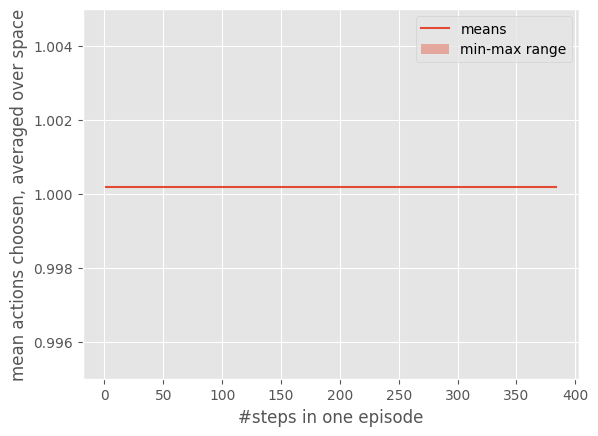

In [11]:
act_means = np.array(act_means)
act_maxs =np.array( act_maxs)
act_mins =np.array( act_mins)
act_stds =np.array( act_stds)
std_means = np.array(std_means)

#this plots the mean, max and min of actions computed over space as a plot over the time of one episode
t = np.linspace(1, len(act_means),len(act_means))
plt.figure()
plt.plot(t, act_means, label="means")
plt.fill_between(t, act_mins, act_maxs, alpha=0.4, label="min-max range")
#plt.fill_between(t, act_means-act_stds, act_means+act_stds, alpha=0.4, label="min-max range")
#plt.plot(t, act_mins, label="mins")
#plt.plot(t, act_maxs, label="maxs")
plt.ylim([0.995,1.005])
plt.legend()
plt.xlabel("#steps in one episode")
plt.ylabel("mean actions choosen, averaged over space")
plt.show()

In [14]:
obs, inf = test_env.reset()
mean, std = policy(Batch(obs=np.array([obs]), info={})).logits.detach().cpu().numpy()
acts_taken = policy(Batch(obs=np.array([obs]), info={})).act.detach().cpu().numpy().reshape(128,128)
mean, std = mean.reshape(128,128), std.reshape(128,128)
v = test_env.get_vorticity()

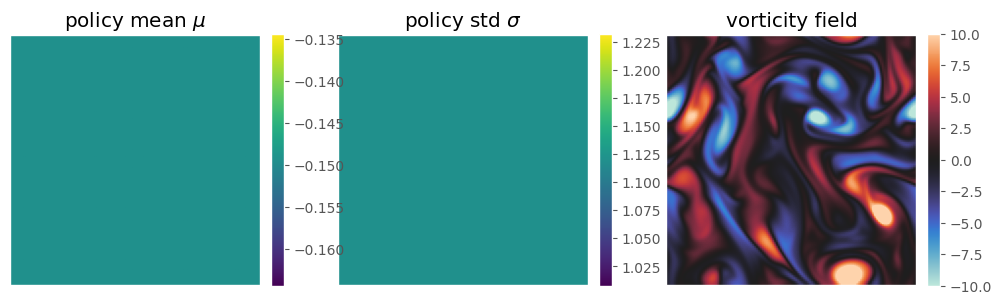

: 

In [15]:
plot_policy(mean, std, v)

In [ ]:
# seed 33 
# t = 14
# -> play the policy for 

In [47]:
# Directly access the last layer
last_layer = policy.actor.sigma[0]

# Print weights and biases
print("Weights of the last layer:\n", last_layer.weight.data)
print("Biases of the last layer:\n", last_layer.bias.data)

Weights of the last layer:
 tensor([[[[ 5.6850,  5.6901,  5.6914],
          [ 5.7215,  5.7125,  5.7196],
          [ 5.6858,  5.6825,  5.6742]],

         [[-6.2812, -6.2841, -6.2997],
          [-6.2537, -6.2517, -6.2591],
          [-6.2766, -6.2670, -6.2766]],

         [[ 5.4605,  5.4451,  5.4534],
          [ 5.3886,  5.3798,  5.3844],
          [ 5.4581,  5.4422,  5.4521]]]], device='cuda:0')
Biases of the last layer:
 tensor([4.3361], device='cuda:0')


: 

In [19]:
# load training stats
with open(DUMP_PATH+'training_stats_'+ID+'.pkl', 'rb') as f:
    stats = pickle.load(f)

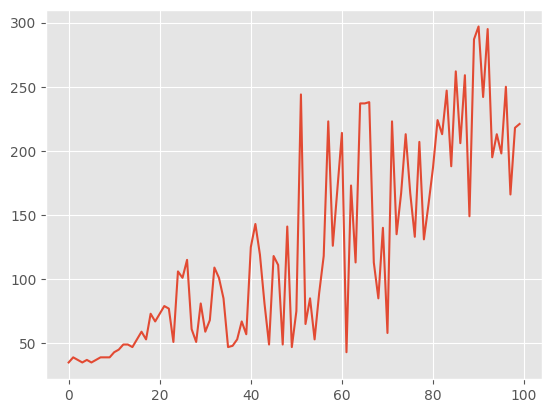

: 

In [29]:
plt.plot(stats["rew"])
#stats[0]

# develop entropic LBM

In [4]:
env = KolmogorovEnvironment7(seeds=train_seeds, max_episode_steps=1536-1, step_factor=1)

m = 310.3835047163428, m_prime = 1535.9999999999998, end time = 1536 steps, T=18, io_rate = 66.78260869565216, Number of outputs = 25.0
m = 4966.136075461485, m_prime = 24575.999999999996, end time = 24576 steps, T=18, io_rate = 1068.5217391304345, Number of outputs = 25.0


In [5]:
f1 = env.f1
rho1, u1 = env.cgs.update_macroscopic(f1)
feq = env.cgs.equilibrium(rho1, u1, cast_output=False)

In [10]:
import jax.numpy as jnp
from jax import grad, vmap

def entropic_equilibrium(rho, u, cast_output=True):
    #cx = [0, 0, 0, 1, -1, 1, -1, 1, -1]
    #cy = [0, 1, -1, 0, 0, -1, 1, 1, -1]
    #c = jnp.array(tuple(zip(cx, cy)))
    #w = 1.0 / 36.0 * np.ones(9)
    #w[np.linalg.norm(c, axis=1) < 1.1] = 1.0 / 9.0
    #w[0] = 4.0 / 9.0
    c = env.cgs.c
    w = env.cgs.w

    ones = jnp.ones_like(u)
    usqr = jnp.square(u) * 3
    S = jnp.sqrt(usqr + ones)
    A = 2 * ones - S
    B = (2 * u + S) / (1 - u + 1e-10)
    def f_eq_i(w, c, A, B, rho):
        return w * jnp.squeeze(rho) * (A[..., 0] * jnp.power(B[..., 0], c[0])) * (A[..., 1] * jnp.power(B[..., 1], c[1]))
    
    def vmap_f_eq(w_batched, c_batched, A, B, rho):
        return vmap(f_eq_i, in_axes=(0, 1, None, None, None), out_axes=-1)(w_batched, c_batched, A, B, rho)
    
    f_eq = vmap_f_eq(w, c, A, B, rho)
    return f_eq
        

In [7]:
#cx = [0, 0, 0, 1, -1, 1, -1, 1, -1]
#cy = [0, 1, -1, 0, 0, -1, 1, 1, -1]
#c = jnp.array(tuple(zip(cx, cy)))
#w = 1.0 / 36.0 * np.ones(9)
#w[np.linalg.norm(c, axis=1) < 1.1] = 1.0 / 9.0
#w[0] = 4.0 / 9.0

In [11]:
feq2 = entropic_equilibrium(rho1, u1)

In [12]:
feq2.shape

(128, 128, 9)

In [13]:
def entropy(f, w):
    return jnp.sum(f * jnp.log((f/env.cgs.w)), axis=-1, keepdims=False)

In [17]:
H = lambda f: jnp.sum(f * jnp.log((f/env.cgs.w)), axis=-1, keepdims=False)
F = lambda alpha: jnp.sum(H(f1 + alpha * (feq2-f1)) - H(f1), axis=-1)

In [19]:
alpha = 2*np.ones((128,128,1))
H1 = H(f1)
H2 = H(f1 + alpha * (feq2-f1))

In [22]:
for i in range(2,5):
    for j in range(22,25):
        #print(H(f1)[i,j] > H(feq)[i,j] > H(feq2)[i,j])
        #print(H(f1)[i,j], H(feq)[i,j], H(feq2)[i,j])
        print(H1[i,j], H2[i,j])

-0.0006449550431269985 -0.0006449569141048992
-0.0007071663237290416 -0.0007071672733164106
-0.0007737557412829091 -0.0007737556525300678
-0.0006892620007823956 -0.0006892618943470415
-0.0007450231773668595 -0.0007450221278895604
-0.0008071996358707597 -0.0008071985890864651
-0.0006997436883678159 -0.0006997428423693767
-0.0007542864313456227 -0.0007542857009585284
-0.0008173836029981333 -0.0008173828976340452


In [14]:
w = env.cgs.w

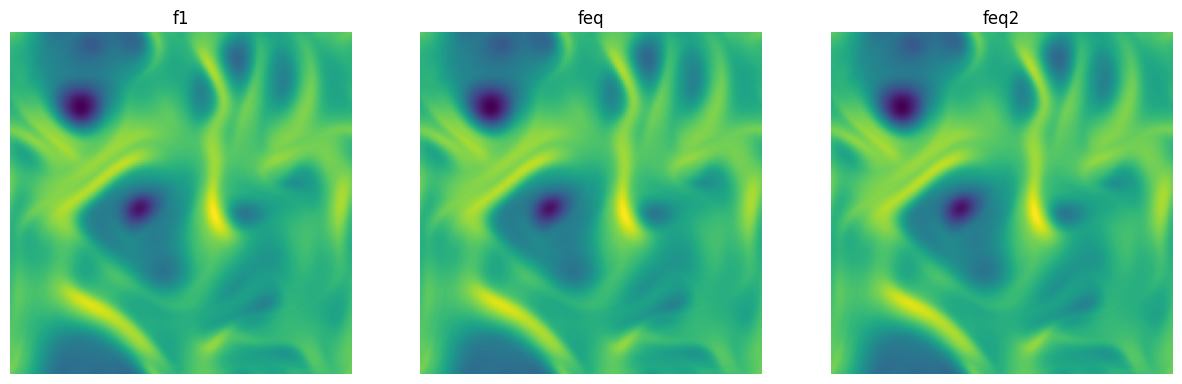

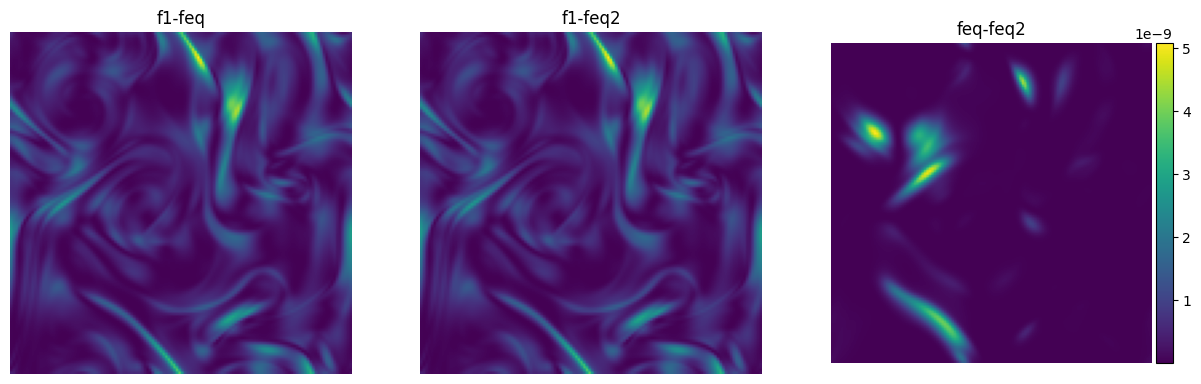

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
im1 = ax1.imshow(entropy(f1, w))
im2 = ax2.imshow(entropy(feq, w))
im3 = ax3.imshow(entropy(feq2, w))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title("f1")
ax2.set_title("feq")
ax3.set_title("feq2")
# Create a colorbar for the third plot
#divider = make_axes_locatable(ax3)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#fig.colorbar(im3, cax=cax)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
im1 = ax1.imshow(np.abs(entropy(f1, w) - entropy(feq, w)))
im2 = ax2.imshow(np.abs(entropy(f1, w) - entropy(feq2, w)))
im3 = ax3.imshow(np.abs(entropy(feq, w) - entropy(feq2, w)))
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax1.set_title("f1-feq")
ax2.set_title("f1-feq2")
ax3.set_title("feq-feq2")
# Create a colorbar for the third plot
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im3, cax=cax)
plt.show()

In [269]:
# classical BGK step
fneq = f1 - feq
fout = f1 - env.cgs.omega * fneq
if env.cgs.force is not None:
    fout = env.cgs.apply_force(fout, feq, rho1, u1)

Array([0.44444444, 0.11111111, 0.11111111, 0.11111111, 0.02777778,
       0.02777778, 0.11111111, 0.02777778, 0.02777778], dtype=float64)

In [37]:
def find_alpha(f, f_eq, guess):
        H = lambda f: jnp.sum(f * jnp.log((f/w)), axis=-1, keepdims=True)
        F = lambda alpha: jnp.sum(H(f + alpha * (f_eq-f)) - H(f), axis=-1)
        grad_f = grad(F)
        alpha = guess
        for _ in range(100):
            F_alpha = F(alpha)
            dF_alpha = grad_f(alpha)
            alpha = alpha - F_alpha / dF_alpha
        alpha = jnp.where((alpha<1.) | (alpha > 3.) | (alpha == "nan"), 2.0, alpha)
        return alpha
    

def find_row_alphas(f_row, f_eq_row, guess_row):
        return vmap(find_alpha, in_axes=(0,0,0))(f_row, f_eq_row, guess_row)

def find_all_alpha(f_grid, f_eq_grid, guess_grid):
    return vmap(find_row_alphas, in_axes=(0,0,0))(f_grid, f_eq_grid, guess_grid)

In [38]:
# Entropic step
f_neq2 = f1 - feq2
alpha_guess = 1.99*jnp.ones((128,128))
alpha = find_all_alpha(f1, feq2, alpha_guess)
fout2 = f1 - alpha[..., jnp.newaxis] * 0.5 * env.cgs.omega * f_neq2
if env.cgs.force is not None:
    fout2 = env.cgs.apply_force(fout2, feq2, rho1, u1)

In [39]:
alpha.max()

Array(2.00086609, dtype=float64)

In [40]:
print(alpha.mean())
print(alpha.std())
print(alpha.max())
print(alpha.min())

1.9999919744701702
0.00011993499507514395
2.0008660923861963
1.99861511834923


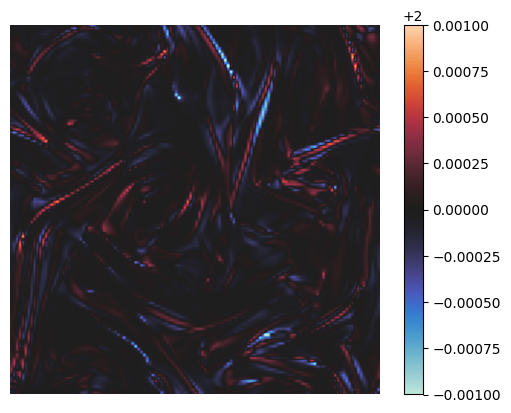

In [44]:
plt.figure()
plt.imshow(alpha, vmin=1.999, vmax=2.001, cmap=sn.cm.icefire)
plt.colorbar()
plt.axis("off")
plt.show()

In [42]:
alpha.min()

Array(1.99861512, dtype=float64)

In [45]:
env.close()

: 

In [12]:
#env.close()
train_env.close()
test_env.close()
#trainer.reset()